In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from IPython import display
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [27]:
def Scaled_Dot_Product_Attention(Q, K, V):
    QK = tf.matmul(Q, K, transpose_b=True)
    dK = tf.cast(tf.shape(K)[-1], tf.float32)
    Scaled_QK = QK / tf.sqrt(dK)
    Attention_Weights = tf.nn.softmax(Scaled_QK, axis = -1)
    Output = tf.matmul(Attention_Weights, V)
    return Output, Attention_Weights

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, feat, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.feat = feat

        self.Wq = tf.keras.layers.Dense(d_model)
        self.Wk = tf.keras.layers.Dense(d_model)
        self.Wv = tf.keras.layers.Dense(d_model)
        self.Wo = tf.keras.layers.Dense(feat)

    def Split_Heads(self, X, batch_size):      
        Multi_Head_X = tf.reshape(X, (batch_size, -1, self.num_heads, self.depth))
        Multi_Head_X = tf.transpose(Multi_Head_X, perm = [0, 2, 1, 3])
        return Multi_Head_X

    def call(self, Q, K, V):        
        batch_size = tf.shape(Q)[0]

        Q = self.Split_Heads(self.Wq(Q), batch_size)
        K = self.Split_Heads(self.Wk(K), batch_size)
        V = self.Split_Heads(self.Wv(V), batch_size)

        Scaled_Attention, Attention_Weights = Scaled_Dot_Product_Attention(Q, K , V)
        Scaled_Attention = tf.transpose(Scaled_Attention, perm = [0, 2, 1, 3])
        Concat_Attention = tf.reshape(Scaled_Attention, (batch_size, -1, self.d_model))
        Output = self.Wo(Concat_Attention)

        return Output, Attention_Weights

In [29]:
class SelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, feat, d_model, dff, dropout_rate, num_heads):
        super(SelfAttentionLayer, self).__init__()
        self.Attention = MultiHeadAttention(feat, d_model, num_heads)
        self.Dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.Dropout2 = tf.keras.layers.Dropout(dropout_rate)

        self.BatchNorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.BatchNorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)

        self.FeedForward = tf.keras.models.Sequential([
                           tf.keras.layers.Dense(dff, activation = 'relu'),
                           tf.keras.layers.Dense(d_model, activation = 'relu'),
                           tf.keras.layers.Dense(feat)
                        ])

    def call(self, X, training):           
        Attention_Output, Attention_Weights = self.Attention(X, X, X)
        Attention_Output = self.Dropout1(Attention_Output, training = training)

        R = self.BatchNorm1(X + Attention_Output)
        FFN_Output = self.FeedForward(R)
        FFN_Output = self.Dropout2(FFN_Output, training = training)

        Z = self.BatchNorm2(R + FFN_Output)

        return Z, Attention_Weights

In [30]:
class CNNBase(tf.keras.layers.Layer):
    def __init__(self):
        super(CNNBase, self).__init__()
        self.Conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation= 'relu')
        self.Conv2 = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation= 'relu')
        self.Conv3 = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation= 'relu')

        self.BN1 = tf.keras.layers.BatchNormalization() 
        self.BN2 = tf.keras.layers.BatchNormalization() 
        self.BN3 = tf.keras.layers.BatchNormalization()

        self.Dropout1 = tf.keras.layers.Dropout(rate=0.2) 
        self.Dropout2 = tf.keras.layers.Dropout(rate=0.2) 
        self.Dropout3 = tf.keras.layers.Dropout(rate=0.2)
     
        self.MaxPool1 = tf.keras.layers.MaxPool2D() 
        self.MaxPool2 = tf.keras.layers.MaxPool2D() 
        self.MaxPool3 = tf.keras.layers.MaxPool2D()

    def call(self, X, training):
        X = self.Conv1(X)
        X = self.BN1(X)
        X = self.MaxPool1(X)
        X = self.Dropout1(X, training=training)
        X = self.Conv2(X)
        X = self.BN2(X)
        X = self.MaxPool2(X)
        X = self.Dropout2(X, training=training)
        X = self.Conv3(X)
        X = self.BN3(X)
        X = self.MaxPool3(X)
        X = self.Dropout3(X, training=training)
        return X

In [31]:
class InceptionResNet(tf.keras.layers.Layer): 
    def __init__(self):
        super(InceptionResNet, self ).__init__()
        self.Conv1 = tf.keras.layers.Conv2D(32,	(1,	1),	strides	= 1, padding = 'same', activation= 'relu')
        self.Conv2 = tf.keras.layers.Conv2D(32,	(1,	1),	strides	= 1, padding = 'same', activation= 'relu')
        self.Conv3 = tf.keras.layers.Conv2D(32,	(3,	3),	strides	= 1, padding = 'same', activation= 'relu')
        self.Conv4 = tf.keras.layers.Conv2D(32,	(1,	1),	strides	= 1, padding = 'same', activation= 'relu')
        self.Conv5 = tf.keras.layers.Conv2D(48,	(3,	3),	strides	= 1, padding = 'same', activation= 'relu')
        self.Conv5 = tf.keras.layers.Conv2D(48,	(3,	3),	strides	= 1, padding = 'same', activation= 'relu')
        self.Conv6 = tf.keras.layers.Conv2D(64,	(3,	3),	strides	= 1, padding = 'same', activation= 'relu')
        self.Merge = tf.keras.layers.Concatenate(axis =	-1)			
        self.Conv7 = tf.keras.layers.Conv2D(64,	(1,	1),	strides	= 1, padding = 'same', activation= 'relu')
        self.BatchNorm = tf.keras.layers.BatchNormalization(axis = -1)
        self.Activation = tf.keras.layers.Activation(activation = 'relu')

    def call(self, X, scale):
        X_a = self.Conv1(X)
        X_b1 = self.Conv2(X)
        X_b2 = self.Conv3(X_b1)
        X_c1 = self.Conv4(X)
        X_c2 = self.Conv5(X_c1)
        X_c3 = self.Conv6(X_c2)
        X_merged = self.Merge([X_a, X_b2, X_c3])
        X_final = self.Conv7(X_merged)
        X_final = self.BatchNorm(X_final)
        Output = self.Activation((X + X_final)) * scale        
        return Output

In [32]:
class ConvSelfAttention(tf.keras.models.Model):
    def __init__(self, feat, seq_len, num_layers, d_model, dff, num_heads, num_classes, num_inc, dropout_rate = 0.1):
        super(ConvSelfAttention, self).__init__()

        self.num_layers = num_layers
        self.d_model = d_model
        self.num_inc = num_inc
        self.ConvBase = CNNBase()
        self.Inception = [InceptionResNet() for _ in range(num_inc)]
        self.Attention_Layers = [SelfAttentionLayer(feat, d_model, dff, dropout_rate, num_heads) for _ in range(num_layers)]        
        self.Flatten = tf.keras.layers.Flatten(input_shape = (seq_len, d_model))
        self.Feature_Layer = tf.keras.layers.Dense(d_model, activation = 'relu')
        self.BatchNorm = tf.keras.layers.BatchNormalization()
        self.Dropout = tf.keras.layers.Dropout(dropout_rate)
        self.classifier = tf.keras.layers.Dense(num_classes)

    def get_dims_ready_for_attention(self, batch_size, X):
        return tf.reshape(X, [batch_size, tf.shape(X)[1], tf.reduce_prod(tf.shape(X)[2:])])

    def call(self, X, training):
        batch_size = tf.shape(X)[0]
        Attention_Weights = {}
        
        X = self.ConvBase(X, training=training)

        for i in range(self.num_inc):
            X = self.Inception[i](X, 0.1)

        X = self.get_dims_ready_for_attention(batch_size, X)

        for i in range(self.num_layers):
            X, Att_W = self.Attention_Layers[i](X, training=training)
            Attention_Weights[f'Block_{i}'] = Att_W

        Flattened = self.Flatten(X)
        Features = self.Feature_Layer(Flattened)
        Features = self.Dropout(self.BatchNorm(Features), training = training)
        Classifier = self.classifier(Features)

        return Classifier, Attention_Weights

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        min_part = tf.minimum(tf.math.rsqrt(step), step * (self.warmup_steps ** (-1.5)))
        lrate = tf.math.rsqrt(self.d_model) * min_part

        return lrate

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

train_cost = tf.keras.metrics.Mean(name='train_cost')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')
val_cost = tf.keras.metrics.Mean(name='val_cost')
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='val_acc')

In [ ]:
def get_feat(x):
    c = CNNBase()
    inc = InceptionResNet()

    x = c(x, True)
    x = inc(x, 0.1)

    x = tf.reshape(x, [tf.shape(x)[0], tf.shape(x)[1], tf.reduce_prod(tf.shape(x)[2:])])

    return x.shape[-1]

sample = X[tf.newaxis, ...]  # X is your dataset
feat = get_feat(sample)
d_model = 1028  
dff = 512
num_layers = 6    # Number of self-attention layer
num_heads = 8     # Number of heads
seq_len = X.shape[0]
num_classes = 2
num_inc = 2       # Number of inception blocks

batch_sample, batch_labels = next(iter(train_ds))    # train_ds is your training data in tensorflow dataset format

model = ConvSelfAttention(feat, seq_len, num_layers, d_model, dff, num_heads, num_classes, num_inc)
model(batch_sample)
model.summary()

In [48]:
def train_step(X, y):
    with tf.GradientTape() as tape:
        pred, att_weights = model(X, training = True)
        loss = loss_object(y, pred)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_cost(loss)
    train_acc(y, pred)

def val_step(X, y):
    with tf.GradientTape() as tape:
        pred, att_weights = model(X, training = False)
        loss = loss_object(y, pred)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    val_cost(loss)
    val_acc(y, pred)

In [ ]:
History = {'Training Loss': [], 'Training Accuracy': [], 'Validation Loss': [], 'Validation Accuracy': []}

EPOCHS = 50

for epoch in range(EPOCHS):
    train_cost.reset_states()
    train_acc.reset_states()
    val_cost.reset_states()
    val_acc.reset_states()

    for batch, label in tqdm(train_ds):
        train_step(batch, label)

    for batch, label in tqdm(val_ds):
        val_step(batch, label)

    History['Training Loss'].append(train_cost.result())
    History['Training Accuracy'].append(train_acc.result())
    History['Validation Loss'].append(val_cost.result())
    History['Validation Accuracy'].append(val_acc.result())

    model.save_weights(f'./self_attention_weights/weight_{epoch+1}')
    print(f'Epoch: {epoch+1}\nTrain loss: {train_cost.result()}\nValidation loss: {val_cost.result()}\nTrain accuracy: {train_acc.result()}\nValidation accuracy: {val_acc.result()}\n{"-"*100}\n')

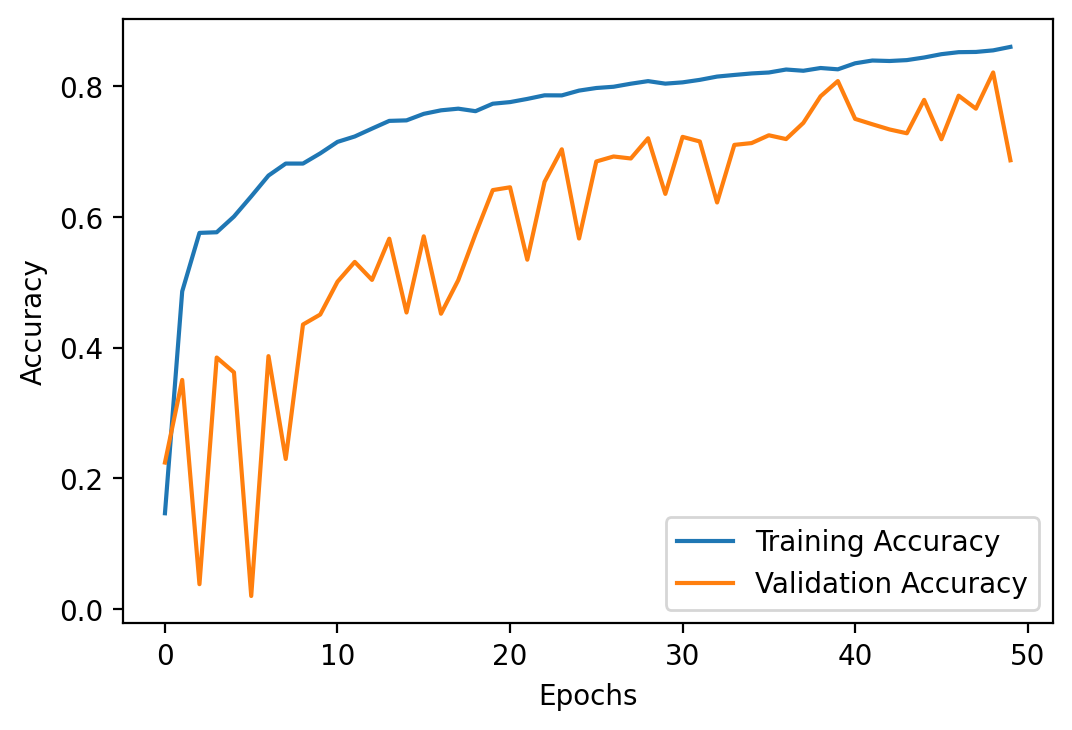

In [219]:
metrics = History
num_epochs = np.arange(EPOCHS)

plt.figure(dpi = 200)
plt.plot(num_epochs, metrics['Training Accuracy'], label = 'Training Accuracy')
plt.plot(num_epochs, metrics['Validation Accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [230]:
history_csv = pd.DataFrame(History).applymap(lambda x: str(x).split(', shape')[0].replace('tf.Tensor(', ''))
history_csv.to_csv('./Self-Attention_results.csv', index=False)